Status: In progress (Last update: Alba Dec 3)
        --> See spectrum section 8)

# Inverse Compton Scattering  

This notebook derives inverse Compton scattering:

1. **Boost the incident photon from the Lab Frame → Electron Rest Frame (ERF)**  
   using the Lorentz transformation matrix  
   $
   \Lambda_z(\beta)=
   \begin{pmatrix}

   \gamma & 0 & 0 & -\gamma\beta\\
   0 & 1 & 0 & 0\\
   0 & 0 & 1 & 0\\
   -\gamma\beta & 0 & 0 & \gamma
   \end{pmatrix}
   $

2. **Compute scattering in the ERF**, using either:  
   - **Klein–Nishina formula** for full relativistic Compton scattering, or  
   - **Thomson limit** for low-energy photons.

3. **Boost the scattered photon from ERF → Lab Frame**, again using the Lorentz matrix.

4. **Evaluate and plot the frequency ratio**  

$
\frac{\tilde{\nu}}{\nu}\quad \text{as a function of the lab scattering angle } \theta_s
$




## 0) Setup and Physical Constants


In [3]:

import numpy as np
import math
import matplotlib.pyplot as plt

# Physical constants (SI)
h = 6.62607015e-34       # Planck (J s)
c = 2.99792458e8         # speed of light (m/s)
me = 9.10938356e-31      # electron mass (kg)
me_c2 = me * c**2        # electron rest energy (J)



## 1) Lorentz Boost Matrix Along +z (Lab → ERF)

We consider an electron moving along the \(+z\)-axis with speed $\beta c$.  
Its Lorentz factor is

$$
\gamma = \frac{1}{\sqrt{1-\beta^{2}}}.
$$

To transform quantities between the Lab Frame and the Electron Rest Frame (ERF), we use the Lorentz boost matrix along the \(z\)-direction.

The matrix used in the notes for a boost from the lab frame to the ERF is

$$
\Lambda(\beta)=
\begin{pmatrix}
\gamma & 0 & 0 & -\gamma\beta\\[6pt]
0 & 1 & 0 & 0\\[6pt]
0 & 0 & 1 & 0\\[6pt]
-\gamma\beta & 0 & 0 & \gamma
\end{pmatrix}.
$$

This matrix mixes the time component \(A^0\) and the \(z\)-component \(A^3\) of any four-vector, while leaving the \(x\) and \(y\) components unchanged.

Because Lorentz boosts are symmetric under $(\beta \to -\beta)$,  the inverse boost (ERF → lab) is obtained simply by flipping the sign of$ \beta$:

$$
\Lambda^{-1}(\beta) = \Lambda(-\beta).
$$

If a four-vector is written as

$$
A^\mu = \big(A^0,\; A^1,\; A^2,\; A^3\big),
$$

then its transformed components in the ERF are given by

$$
A'^\mu = \Lambda^\mu{}_{\nu}\,A^{\nu}.
$$

This rule applies to photons (their four-momentum), to electrons, and to any other relativistic four-vector.


In [4]:

def gamma_from_beta(beta: float) -> float:
    beta = np.clip(beta, 0.0, 1.0 - 1e-15)
    return 1.0 / np.sqrt(1.0 - beta**2)

def beta_from_gamma(gamma: float) -> float:
    gamma = max(gamma, 1.0)
    return np.sqrt(1.0 - 1.0/gamma**2)

def boost_matrix_z(beta: float) -> np.ndarray:
    g = gamma_from_beta(beta)
    return np.array([[ g, 0.0, 0.0, -g*beta],
                     [0.0, 1.0, 0.0,  0.0   ],
                     [0.0, 0.0, 1.0,  0.0   ],
                     [-g*beta, 0.0, 0.0, g  ]], dtype=float)

def apply_boost_z(fourvec: np.ndarray, beta: float) -> np.ndarray:
    # Return Lambda(beta) times fourvec
    return boost_matrix_z(beta) @ fourvec


## 2) Doppler shift and aberration (derived using the boost matrix $\Lambda$)

For a **photon** with lab energy $\,\epsilon = h\nu\,$ and lab direction $(\theta,\phi)$ relative to $+z$:

**Photon four-momentum in the lab**
$$
k^\mu
=\left(\frac{\epsilon}{c},\;\frac{\epsilon}{c}\sin\theta\cos\phi,\;\frac{\epsilon}{c}\sin\theta\sin\phi,\;\frac{\epsilon}{c}\cos\theta\right).
$$

Applying the Lorentz boost $\,k'^\mu=\Lambda^\mu{}_{\nu}\,k^{\nu}\,$ gives the standard relations:

**Energy (lab $\rightarrow$ ERF)**
$$
\epsilon'=\gamma\,\epsilon\,\big(1-\beta\cos\theta\big).
$$

**Aberration (lab $\rightarrow$ ERF)**
$$
\cos\theta'=\frac{\cos\theta-\beta}{\,1-\beta\cos\theta\,},
\qquad
\phi'=\phi.
$$

**Notes.** $\gamma=(1-\beta^2)^{-1/2}$, $\beta=v/c$. The boost is along $+z$, so only the $t$ and $z$ components mix; $\phi$ is unchanged.


In [5]:

def doppler_to_erf(epsilon_lab_J: float, cos_theta: float, beta: float) -> float:
    # epsilon' = gamma * epsilon * (1 - beta * cos(theta))
    g = gamma_from_beta(beta)
    return g * epsilon_lab_J * (1.0 - beta * cos_theta)

def aberration_lab_to_erf(cos_theta: float, beta: float) -> float:
    # cos(theta') = (cos(theta) - beta) / (1 - beta * cos(theta))
    num = cos_theta - beta
    den = 1.0 - beta * cos_theta
    return np.clip(num/den, -1.0, 1.0)



## 3) Compton scattering in the ERF (Klein–Nishina and Thomson limits)

In the electron rest frame (ERF), the scattered photon energy is fixed entirely by
energy–momentum conservation.  
The full **Klein–Nishina** result gives the outgoing ERF energy $\tilde{\epsilon}'$ as

$$
\tilde{\epsilon}' \;=\;
\frac{\epsilon'}
     {\,1 + \displaystyle \frac{\epsilon'}{m_e c^2}\,\big(1 - \cos\Theta'\big)} ,
$$

where $\Theta'$ is the ERF scattering angle between the **incoming** and **outgoing**
photon directions.

---

### Thomson limit

When the incoming photon energy in the ERF is much smaller than the electron rest energy,
$\epsilon' \ll m_e c^2$, we obtain the **Thomson approximation**:

$$
\tilde{\epsilon}' \;\approx\; \epsilon'.
$$

This means that in the Thomson regime, the photon **changes direction** but not energy
(in the ERF).

---

### Functions implemented below

- `epsilon_s_erf_kn(...)`  
  Computes the Klein–Nishina scattered energy in the ERF.

- `epsilon_s_erf_thomson(...)`  
  Returns $\epsilon'$ unchanged, as appropriate for the Thomson limit.


In [6]:

def epsilon_s_erf_kn(eps_in_prime_J: float, cos_Theta_prime: np.ndarray) -> np.ndarray:
    # Klein-Nishina: eps_out' = eps_in' / [1 + (eps_in' / (m_e c^2)) * (1 - cos Theta')]
    x = eps_in_prime_J / me_c2
    return eps_in_prime_J / (1.0 + x * (1.0 - cos_Theta_prime))

def epsilon_s_erf_thomson(eps_in_prime_J: float, shape_like: np.ndarray) -> np.ndarray:
    # Thomson: elastic in ERF; broadcast to match angle array.
    return np.full_like(shape_like, eps_in_prime_J, dtype=float)


## 4) ERF geometry: from $\Theta'$ to the outgoing polar angle (to $+z$)

Let $\theta'_{\text{in}}$ be the **incoming** ERF polar angle relative to $+z$.  
After scattering by an ERF deflection angle $\Theta'$, the **outgoing** ERF polar angle
$\theta'_s$ relative to $+z$ satisfies

$$
\cos\theta'_s
=
\cos\theta'_{\text{in}}\,\cos\Theta'
\;+\;
\sin\theta'_{\text{in}}\,\sin\Theta'
\qquad (\phi'=0\ \text{slice}).
$$

**Interpretation.** This is just the cosine rule on the unit sphere: rotate the incoming
direction by $\Theta'$ in a plane of constant $\phi'$ and read off the new polar angle
to the $+z$ axis. It will feed the ERF $\to$ lab boost for energy and angle.

**Function (next cell):** `cos_theta_out_erf(cos_theta_in_prime, cos_Theta_prime)`


In [7]:

def cos_theta_out_erf(cos_theta_in_prime: float, cos_Theta_prime: np.ndarray) -> np.ndarray:
    # cos(theta_s') = cos(theta_in') * cos(Theta') + sin(theta_in') * sin(Theta')
    theta_in = np.arccos(np.clip(cos_theta_in_prime, -1, 1))
    sin_theta_in = np.sin(theta_in)
    sin_Theta = np.sqrt(1.0 - np.clip(cos_Theta_prime, -1, 1)**2)
    return (cos_theta_in_prime * cos_Theta_prime + sin_theta_in * sin_Theta)


## 5) Boost back to the lab frame (ERF → Lab)

Once the photon is scattered in the ERF, we must transform its energy and angle
back to the laboratory frame. A boost along $+z$ mixes only the time and $z$ components
of the photon four-momentum, giving the standard results:

**Energy (ERF → Lab):**
$$
\epsilon_s
=
\gamma\,\tilde{\epsilon}'\,\big(1+\beta\cos\theta_s'\big).
$$

**Aberration (ERF → Lab):**
$$
\cos\theta_s
=
\frac{\cos\theta_s' + \beta}
     {1 + \beta\cos\theta_s'}.
$$

These follow directly from applying the inverse Lorentz boost  
$\Lambda^{-1}(\beta) = \Lambda(-\beta)$ to the scattered photon 4-vector.

**Functions (next cell):**
- `erf_to_lab_energy_via_matrix(...)` — computes $\epsilon_s$ by boosting the 4-vector with the matrix  
- `aberration_erf_to_lab(...)` — applies the exact aberration formula above



In [8]:

def doppler_to_lab(epsilon_prime_J: np.ndarray, cos_theta_prime_out: np.ndarray, beta: float) -> np.ndarray:
    # epsilon = gamma * epsilon' * (1 + beta * cos(theta'))
    g = gamma_from_beta(beta)
    return g * epsilon_prime_J * (1.0 + beta * cos_theta_prime_out)

def aberration_erf_to_lab(cos_theta_prime_out: np.ndarray, beta: float) -> np.ndarray:
    # cos(theta) = (cos(theta') + beta) / (1 + beta * cos(theta'))
    num = cos_theta_prime_out + beta
    den = 1.0 + beta * cos_theta_prime_out
    return np.clip(num/den, -1.0, 1.0)


## 6) Putting it all together: the ratio $\tilde{\nu}/\nu$ vs. lab scattering angle

Following the sequence in the notes, the full computation proceeds as:

1. Select a lab-frame photon frequency $\nu$ and incidence angle $\theta$.  
   Compute its energy $\epsilon = h\nu$ and $\cos\theta$.

2. Boost from the lab to the ERF using the matrix $\Lambda(\beta)$ to obtain  
   $\epsilon'$ and the incoming ERF angle $\theta'_{\text{in}}$.

3. Sweep the ERF scattering angle $\Theta' \in [0,\pi]$.

4. For each $\Theta'$, compute the outgoing ERF polar angle $\theta'_s$  
   using the spherical-geometry relation.

5. Compute the scattered ERF energy $\tilde{\epsilon}'$ using either  
   the **Klein–Nishina** formula (general case) or the **Thomson** limit (low energy).

6. Boost from ERF back to the lab to obtain $\epsilon_s$ and  
   the output frequency $\tilde{\nu} = \epsilon_s/h$.

7. Convert $\cos\theta'_s$ to lab-frame $\cos\theta_s$ using the aberration formula,  
   then compute $\theta_s$ (in degrees).

8. Plot the gain:
   $$
   \frac{\tilde{\nu}}{\nu}
   \qquad \text{as a function of the lab scattering angle } \theta_s .
   $$

This plot shows how inverse Compton scattering boosts photon energies depending  
on scattering geometry and the electron Lorentz factor $\gamma$.


In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    # Figure size + DPI
    "figure.figsize": (10, 6),
    "figure.dpi": 120,

    # Fonts
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",

    # Titles & labels
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "axes.linewidth": 1.2,

    # Tick labels
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,

    # Lines (NO MARKERS)
    "lines.linewidth": 2.5,
    "lines.markersize": 0,
    "lines.marker": "",          # THIS disables markers safely
    "lines.markeredgewidth": 0,

    # Legend
    "legend.fontsize": 14,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "legend.borderaxespad": 1.0,

    # Grid
    "axes.grid": True,
    "grid.linewidth": 0.6,
    "grid.alpha": 0.4,
})


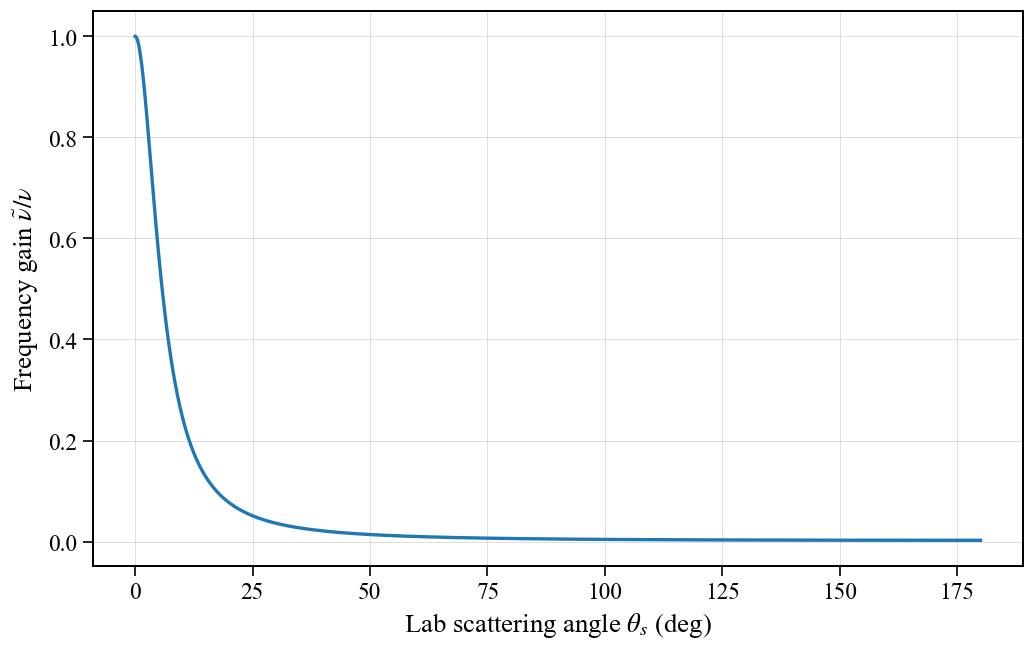

In [10]:

def ics_gain_vs_theta_lab(gamma: float, nu_in_hz: float, theta_in_deg: float,
                          use_klein_nishina: bool = True, n_angles: int = 361):
    beta = beta_from_gamma(gamma)
    eps_lab = h * nu_in_hz
    cos_theta_lab = math.cos(math.radians(theta_in_deg))

    # Lab → ERF
    eps_prime = doppler_to_erf(eps_lab, cos_theta_lab, beta)
    cos_theta_prime_in = aberration_lab_to_erf(cos_theta_lab, beta)

    # Sweep ERF scattering angle Theta'
    Theta_prime = np.linspace(0.0, np.pi, n_angles)
    cos_Theta_prime = np.cos(Theta_prime)

    # Outgoing ERF direction relative to +z
    cos_theta_prime_out = cos_theta_out_erf(cos_theta_prime_in, cos_Theta_prime)

    # ERF scattered energy
    if use_klein_nishina:
        eps_prime_out = epsilon_s_erf_kn(eps_prime, cos_Theta_prime)
    else:
        eps_prime_out = epsilon_s_erf_thomson(eps_prime, cos_Theta_prime)

    # ERF → Lab
    eps_out = doppler_to_lab(eps_prime_out, cos_theta_prime_out, beta)
    nu_out = eps_out / h

    # Outgoing lab angle
    cos_theta_lab_out = aberration_erf_to_lab(cos_theta_prime_out, beta)
    theta_lab_out = np.degrees(np.arccos(np.clip(cos_theta_lab_out, -1, 1)))

    gain = nu_out / nu_in_hz
    return theta_lab_out, gain

# Demo plot
theta_s, gain = ics_gain_vs_theta_lab(gamma=10.0, nu_in_hz=1e14, theta_in_deg=0.0, use_klein_nishina=True)
plt.figure()
plt.plot(theta_s, gain, lw=2)
plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel(r"Frequency gain $\tilde{\nu}/\nu$")
plt.grid(True); plt.show()


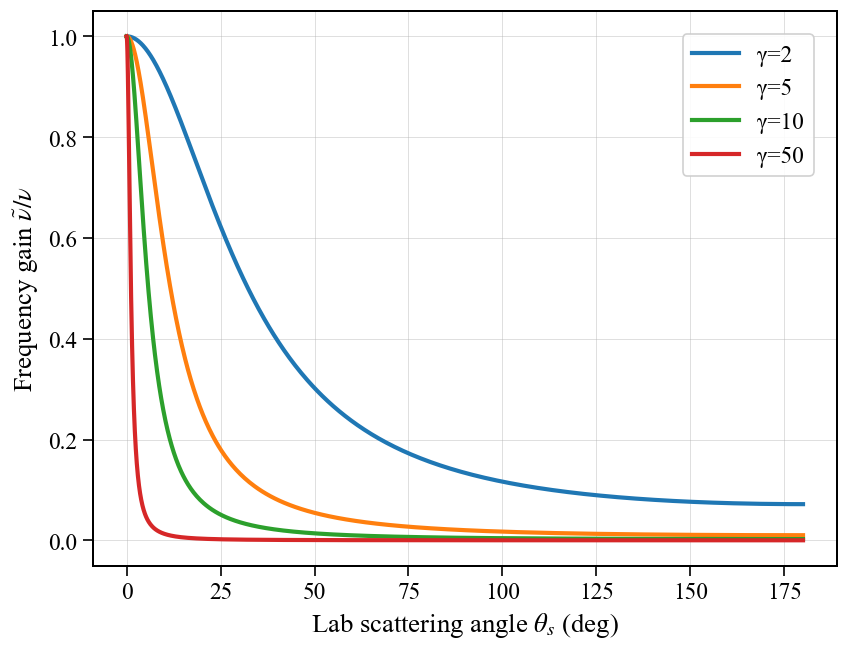

In [11]:
gammas = [2, 5, 10, 50]
nu_in = 1e14
theta_in = 0.0
plt.figure(figsize=(8,6))

for g in gammas:
    theta_s, gain =  ics_gain_vs_theta_lab(g, nu_in, theta_in, use_klein_nishina=True)
    plt.plot(theta_s, gain, label=f"γ={g}")

plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel(r"Frequency gain $\tilde{\nu}/\nu$")
plt.legend()
plt.grid(True)
plt.show()


Higher-$\gamma$ electrons produce stronger forward beaming: the frequency gain peaks sharply near $\theta_s\!\approx\!0^\circ$ and falls off rapidly with angle.


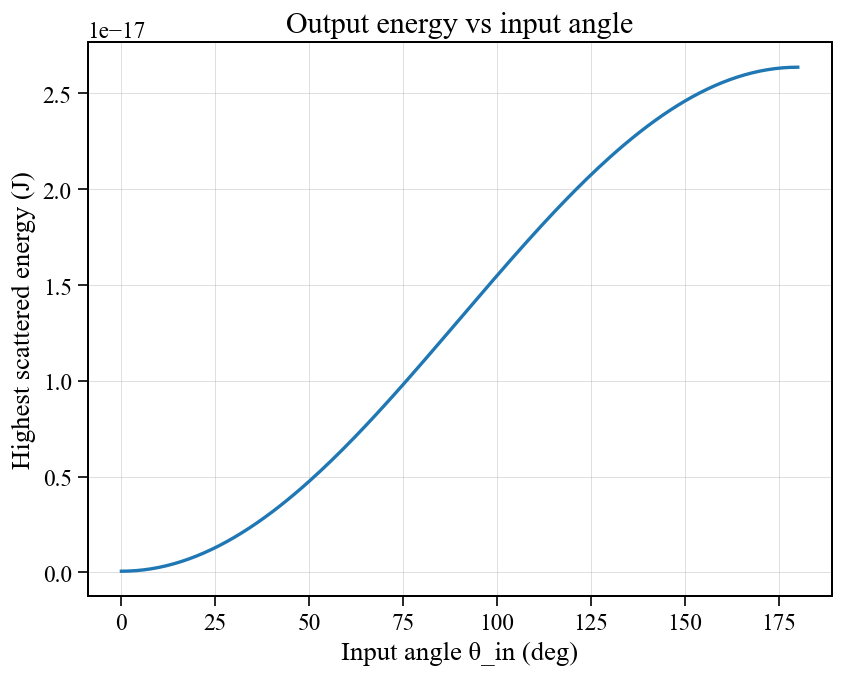

In [12]:
theta_in_vals = np.linspace(0,180,181)
gamma_val = 10
nu_in = 1e14

eps_out_list = []
for th in theta_in_vals:
    theta_s, gain = ics_gain_vs_theta_lab(gamma_val, nu_in, th)
    eps_out_list.append(max(gain)*h*nu_in)  # highest-energy scattered photon

plt.figure(figsize=(8,6))
plt.plot(theta_in_vals, eps_out_list, lw=2)
plt.xlabel("Input angle θ_in (deg)")
plt.ylabel("Highest scattered energy (J)")
plt.title("Output energy vs input angle")
plt.grid(True)
plt.show()


  Photons that hit the electron **head-on** ($\theta_{\rm in}\!\approx\!180^\circ$) get the **largest boost**. Photons moving **with** the electron ($\theta_{\rm in}\!\approx\!0^\circ$) gain little.

Points: 300
Min gain: 0.0025125784721475946 Max gain: 0.9999999999999969


<>:56: SyntaxWarning: invalid escape sequence '\T'
<>:56: SyntaxWarning: invalid escape sequence '\T'
/var/folders/yh/g_zpjd31055bf35m0p9f2fvc0000gp/T/ipykernel_79815/1530359590.py:56: SyntaxWarning: invalid escape sequence '\T'
  plt.title("Mapping ERF $\Theta'$ → lab $\theta_s$ with energy gain")


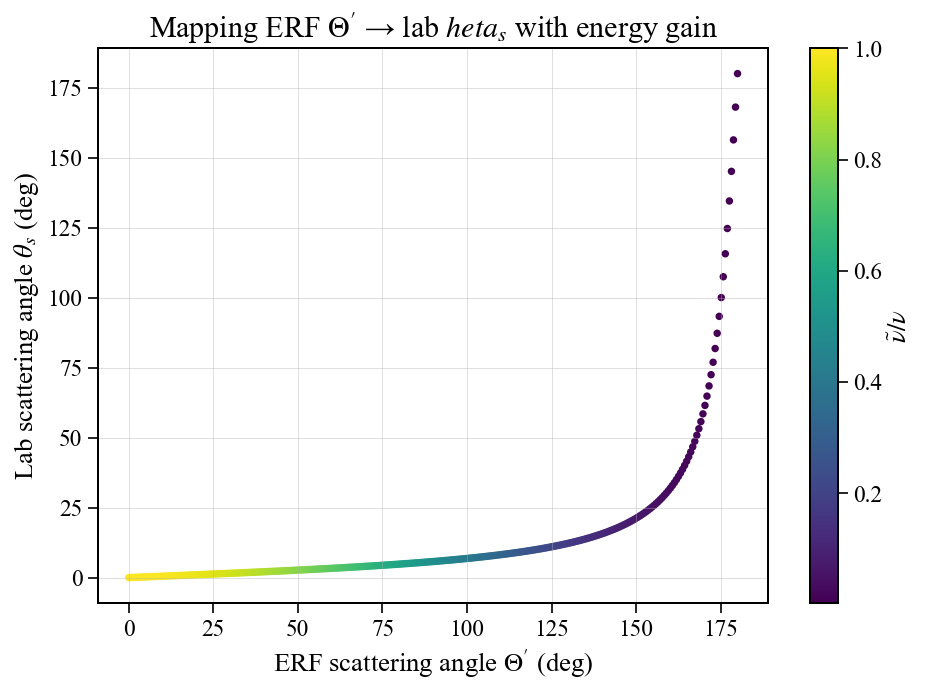

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# PARAMETERS
gamma_val = 10.0
nu_in = 1e14
theta_in = 0.0
beta = beta_from_gamma(gamma_val)

eps_lab = h * nu_in
cos_theta_lab = np.cos(np.radians(theta_in))

# 1) LAB → ERF
eps_prime = doppler_to_erf(eps_lab, cos_theta_lab, beta)
cos_theta_prime_in = aberration_lab_to_erf(cos_theta_lab, beta)

# 2) ERF scattering grid
Theta_prime = np.linspace(0, np.pi, 300)
cos_Theta_prime = np.cos(Theta_prime)

# 3) Outgoing direction in ERF
cos_theta_prime_out = cos_theta_out_erf(cos_theta_prime_in, cos_Theta_prime)

# 4) ERF scattered energy
eps_prime_out = epsilon_s_erf_kn(eps_prime, cos_Theta_prime)

# 5) ERF → LAB energy
eps_out = doppler_to_lab(eps_prime_out, cos_theta_prime_out, beta)
nu_out = eps_out / h
gain = nu_out / nu_in

# 6) LAB angles
cos_theta_lab_out = aberration_erf_to_lab(cos_theta_prime_out, beta)
theta_s_lab = np.degrees(np.arccos(np.clip(cos_theta_lab_out, -1, 1)))

# ---- CLEAN NaNs or infs ----
mask = np.isfinite(theta_s_lab) & np.isfinite(gain)
Theta_prime_clean = Theta_prime[mask]
theta_s_lab_clean = theta_s_lab[mask]
gain_clean = gain[mask]

print("Points:", Theta_prime_clean.size)
print("Min gain:", gain_clean.min(), "Max gain:", gain_clean.max())

# ---- PLOT ----
plt.figure(figsize=(9,6))
sc = plt.scatter(Theta_prime_clean * 180/np.pi,
                 theta_s_lab_clean,
                 c=gain_clean,
                 cmap='viridis',
                 s=12)  # small clean dots

plt.colorbar(sc, label=r"$\tilde{\nu}/\nu$")
plt.xlabel(r"ERF scattering angle $\Theta'$ (deg)")
plt.ylabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.title("Mapping ERF $\Theta'$ → lab $\theta_s$ with energy gain")
plt.grid(True)
plt.show()


Forward ERF scatters map to small lab angles and carry the largest energy boosts, while backward ERF scatters appear at wide lab angles with low gain. This reflects Doppler boosting and relativistic aberration.


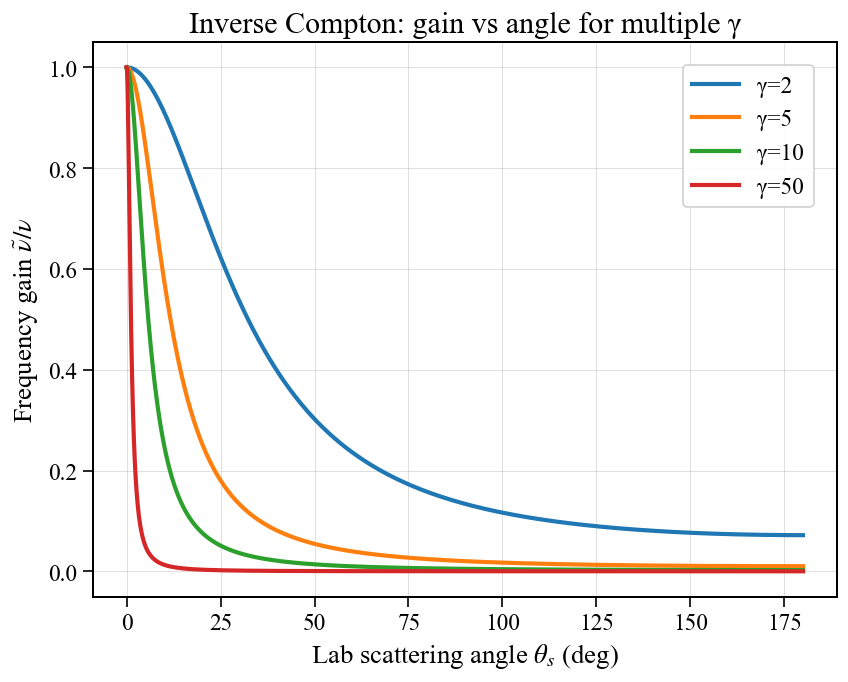

In [14]:
gammas = [2, 5, 10, 50]
nu_in = 1e14
theta_in = 0.0
plt.figure(figsize=(8,6))

for g in gammas:
    theta_s, gain =  ics_gain_vs_theta_lab(g, nu_in, theta_in, use_klein_nishina=True)
    plt.plot(theta_s, gain, label=f"γ={g}")

plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel(r"Frequency gain $\tilde{\nu}/\nu$")
plt.title("Inverse Compton: gain vs angle for multiple γ")
plt.legend()
plt.grid(True)
plt.show()


## 7) Head-on backscatter maximum 

For a head-on lab photon that is back-scattered in the ERF ($\Theta'=\pi$), the maximum scattered photon energy in the lab is
$$
\epsilon_{\max}
= \frac{4\gamma^{2}\,\epsilon}{\,1+\dfrac{4\gamma\,\epsilon}{m_e c^{2}}\,}.
$$

**Limiting regimes**
- **Thomson limit** ($\gamma\epsilon \ll m_e c^{2}$): 
  $$
  \epsilon_{\max} \simeq 4\gamma^{2}\epsilon.
  $$
- **Klein–Nishina (KN) limit** ($\gamma\epsilon \gg m_e c^{2}$): 
  $$
  \epsilon_{\max} \simeq \gamma\,m_e c^{2}.
  $$



In [15]:

def epsilon_max_headon(gamma: float, epsilon_lab_J: float) -> float:
    # eps_max = 4 * gamma^2 * eps / (1 + 4 * gamma * eps / (m_e c^2))
    return (4.0 * gamma**2 * epsilon_lab_J) / (1.0 + 4.0 * gamma * epsilon_lab_J / me_c2)

# Tiny check
eps0 = h * 1e14
epsilon_max_headon(10.0, eps0)


2.6503422599407977e-17

## 8)Spectrum with free–free + saturated inverse Compton

- **Low frequencies (optically thick free–free):**  
  $I_\nu \rightarrow B_\nu(T)$, giving a blackbody (Rayleigh–Jeans $\propto \nu^2$).

- **Intermediate region (modified blackbody):**  
  $I_\nu \simeq B_\nu(T)\,[1-e^{-\tau_{\rm ff}(\nu)}]$ with $\tau_{\rm ff}\propto \nu^{-2}$.  
  In the RJ limit, $B_\nu\propto \nu^2$ and $\tau_{\rm ff}\propto \nu^{-2}$ so  
  $I_\nu \propto \nu^0$ (a flat plateau).

- **High frequencies (saturated Comptonization):**  
  The spectrum approaches a Wien form  
  $I_\nu \propto \nu^3 \exp[-h\nu/(kT_e)]$, matched smoothly at a chosen $\nu_{\rm IC}$.


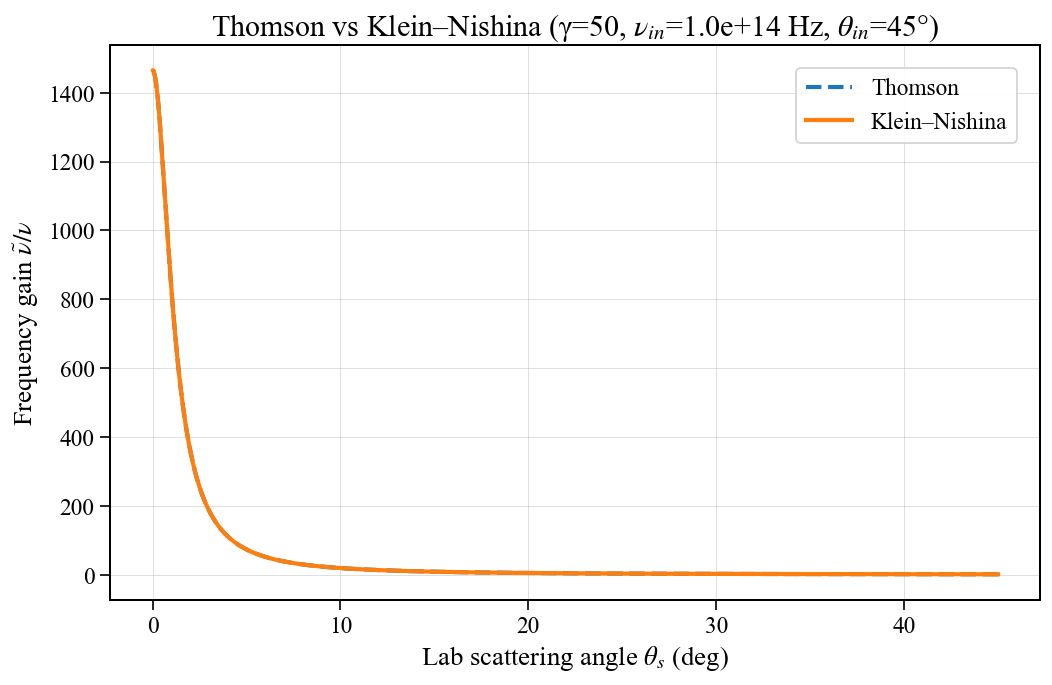

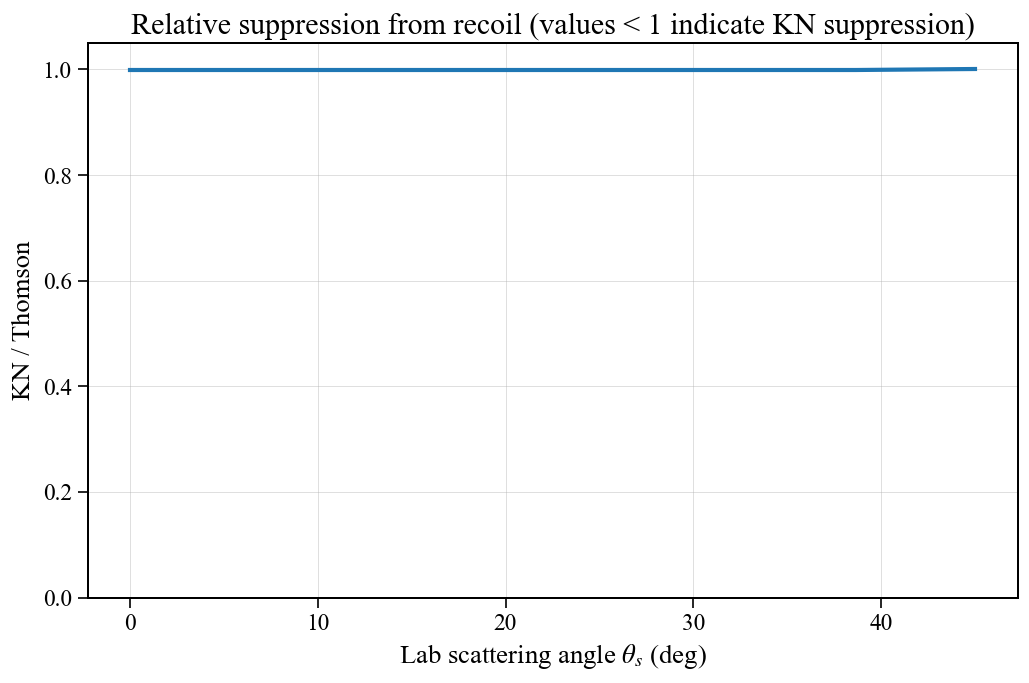

In [27]:
# ---- Parameters ----
gamma_val   = 50        # electron Lorentz factor
nu_in_hz    = 1e14        # incident photon frequency (Hz)
theta_in_deg= 45         # incident angle in lab (deg), 180 = head-on
n_angles    = 361         # resolution

# ---- Compute curves with your existing function ----
theta_T, gain_T = ics_gain_vs_theta_lab(
    gamma=gamma_val, nu_in_hz=nu_in_hz, theta_in_deg=theta_in_deg,
    use_klein_nishina=False, n_angles=n_angles
)
theta_KN, gain_KN = ics_gain_vs_theta_lab(
    gamma=gamma_val, nu_in_hz=nu_in_hz, theta_in_deg=theta_in_deg,
    use_klein_nishina=True, n_angles=n_angles
)

# Ensure same angle grid (they should be, but align just in case)
import numpy as np
theta_common = theta_T
gain_T = np.asarray(gain_T, dtype=float)
gain_KN = np.asarray(gain_KN, dtype=float)

# Clean any non-finite values
mask = np.isfinite(theta_common) & np.isfinite(gain_T) & np.isfinite(gain_KN)
theta_common = theta_common[mask]
gain_T = gain_T[mask]
gain_KN = gain_KN[mask]

# ---- Plot 1: Overlay (Thomson vs KN) ----
plt.figure()
plt.plot(theta_common, gain_T,  linestyle="--", linewidth=2.5, label="Thomson")
plt.plot(theta_common, gain_KN, linestyle="-",  linewidth=2.5, label="Klein–Nishina")

plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel(r"Frequency gain $\tilde{\nu}/\nu$")
plt.title(rf"Thomson vs Klein–Nishina (γ={gamma_val:.0f}, $\nu_{{in}}$={nu_in_hz:.1e} Hz, $\theta_{{in}}$={theta_in_deg:.0f}°)")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot 2: Ratio KN / Thomson ----
ratio = np.divide(gain_KN, gain_T, out=np.zeros_like(gain_KN), where=(gain_T>0))

plt.figure()
plt.plot(theta_common, ratio, linewidth=2.5)
plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel(r"KN / Thomson")
plt.title("Relative suppression from recoil (values < 1 indicate KN suppression)")
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()


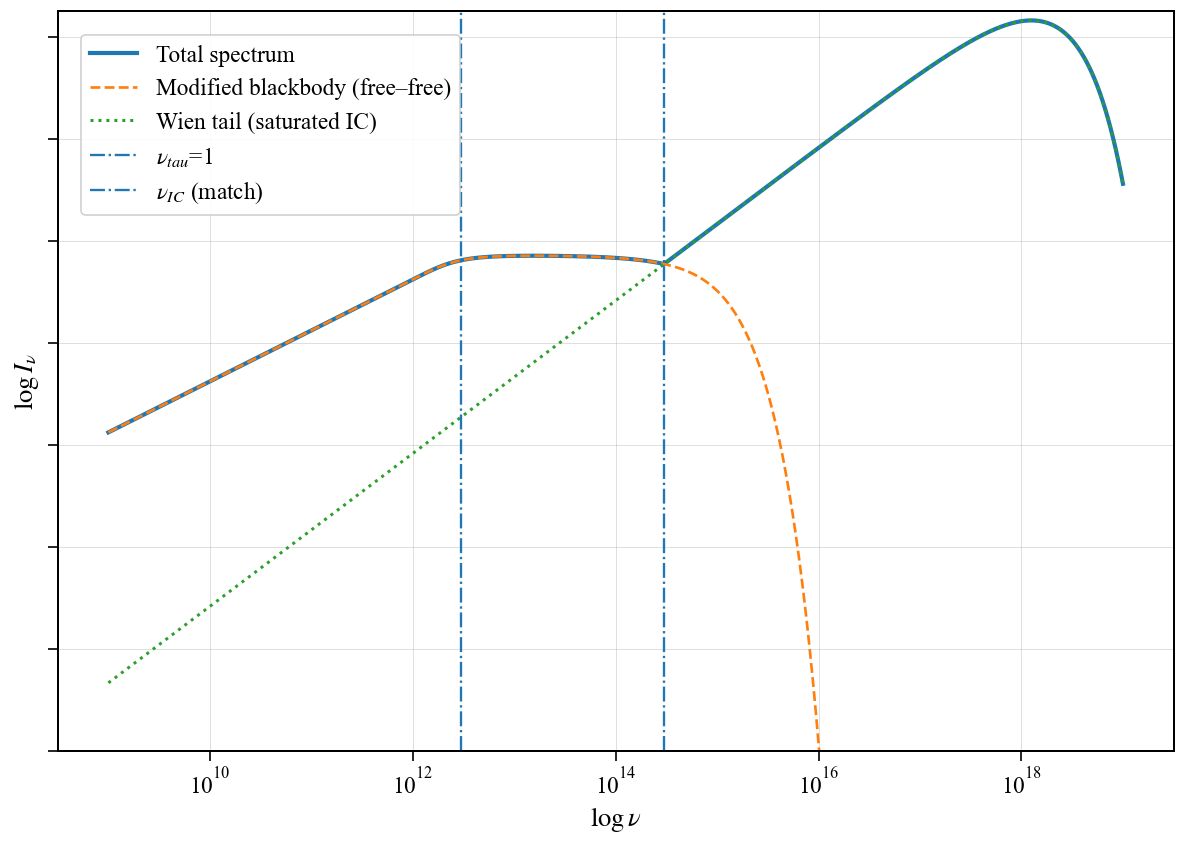

In [53]:
# Corrected spectrum plot (no markdown issues, clean code)

import numpy as np
import matplotlib.pyplot as plt

# --- Physical constants (SI) ---
h  = 6.62607015e-34
kB = 1.380649e-23
c  = 2.99792458e8

def Bnu(nu, T):
    """Planck function B_nu(T) [W m^-2 Hz^-1 sr^-1]."""
    x = h * nu / (kB * T)
    with np.errstate(over='ignore', under='ignore', invalid='ignore'):
        ex = np.exp(np.clip(x, 0, 700))
        return (2*h*nu**3)/(c**2) / (ex - 1.0)

def I_ff_modified(nu, T, nu_tau1):
    """Modified blackbody with free–free absorption: tau_ff = (nu/nu_tau1)^(-2)."""
    tau = (nu/nu_tau1)**(-2.0)
    return Bnu(nu, T) * (1.0 - np.exp(-tau))

def wien_matched(nu, T_e, nu_match, I_match):
    """Wien tail A * nu^3 * exp(-h nu / (k T_e)), normalized at nu_match."""
    Wm = (nu_match**3) * np.exp(-h*nu_match/(kB*T_e))
    A  = I_match / Wm if Wm > 0 else 0.0
    return A * (nu**3) * np.exp(-h*nu/(kB*T_e))

# --- Model parameters ---
T_rad  = 1.0e4        # thermal medium temperature (free–free/blackbody)
nu_tau1 = 3e12        # free–free optical depth unity
T_e    = 2.0e7        # electron temperature for Wien tail
nu_IC  = 3e14         # matching point to Comptonized Wien tail

# Frequency grid
nu = np.logspace(9, 19, 1500)

# Compute components
I_mid = I_ff_modified(nu, T_rad, nu_tau1)
I_match = np.interp(nu_IC, nu, I_mid)
I_wien = wien_matched(nu, T_e, nu_IC, I_match)

# Combine
I_tot = np.where(nu <= nu_IC, I_mid, I_wien)

# Plot
plt.figure(figsize=(12, 8))
plt.loglog(nu, I_tot, linewidth=2.5, label="Total spectrum")
plt.loglog(nu, I_mid, linestyle="--", linewidth=1.6, label="Modified blackbody (free–free)")
plt.loglog(nu, I_wien, linestyle=":", linewidth=1.8, label="Wien tail (saturated IC)")

plt.axvline(nu_tau1, linestyle="-.", linewidth=1.4, label=r"$\nu_{tau}$=1")
plt.axvline(nu_IC,   linestyle="-.", linewidth=1.4, label=r"$\nu_{IC}$ (match)")

plt.xlabel(r"$\log \nu$")
plt.ylabel(r"$\log I_{\nu}$")
plt.legend()
plt.ylim(1e-30,1e-1)
plt.gca().tick_params(axis='y', labelleft=False)

plt.show()


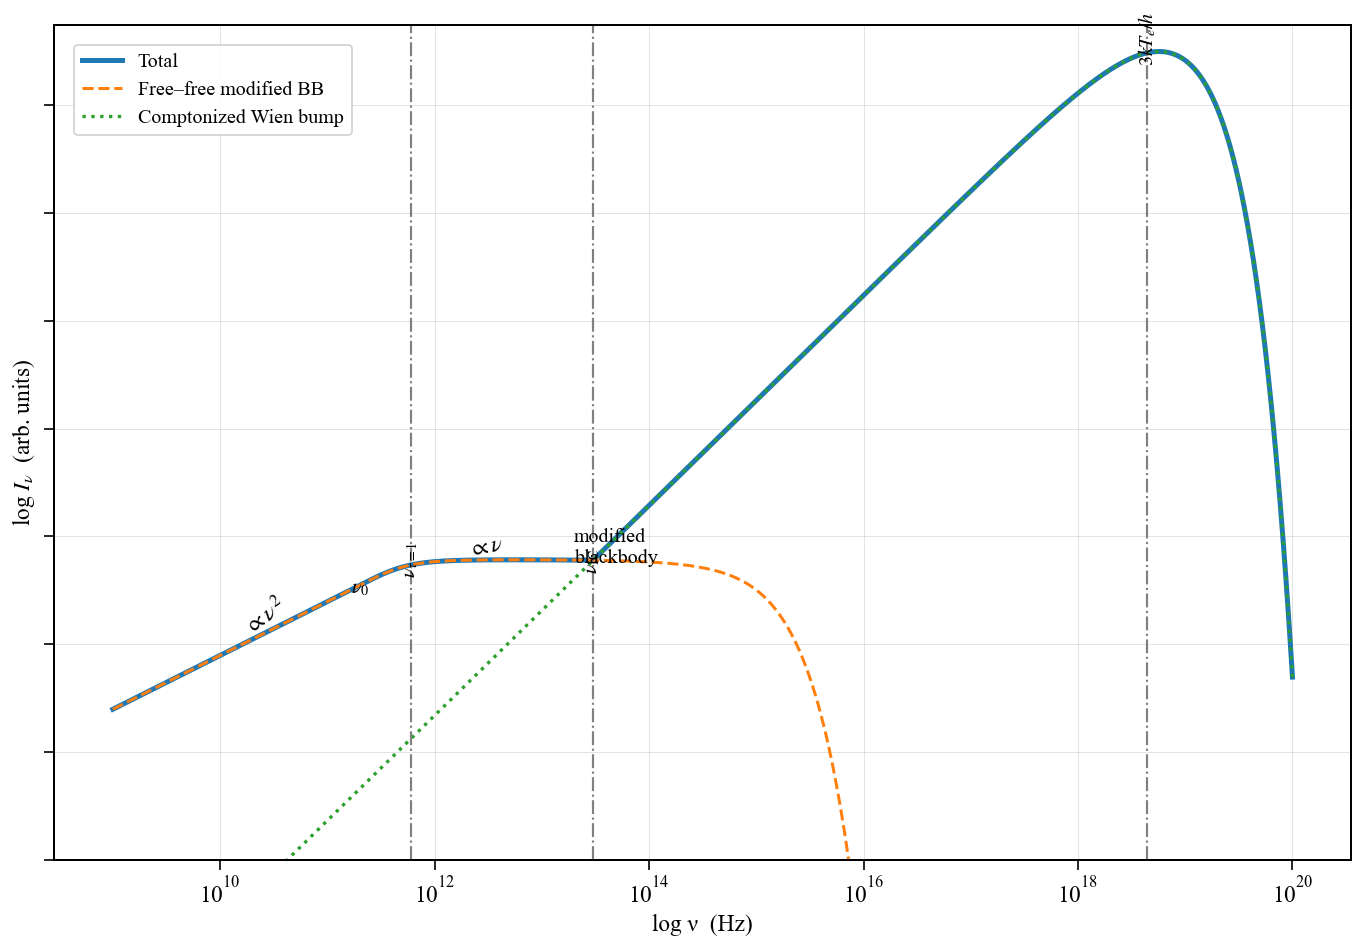

In [54]:
# RL Fig. 7.4 schematic: blackbody  → modified blackbody (free–free) → Comptonized Wien bump
import numpy as np
import matplotlib.pyplot as plt

# ----------------- constants (SI) -----------------
h  = 6.62607015e-34     # J·s
kB = 1.380649e-23       # J/K
c  = 2.99792458e8       # m/s

# ----------------- physics helpers -----------------
def Bnu(nu, T):
    """Planck function B_ν(T) [W m^-2 Hz^-1 sr^-1]."""
    x = h*nu/(kB*T)
    with np.errstate(over='ignore', under='ignore', invalid='ignore'):
        ex = np.exp(np.clip(x, 0, 700))
        return (2*h*nu**3)/(c**2) / (ex - 1.0)

def I_freefree_modified(nu, T, nu_tau1):
    """Modified blackbody with free–free absorption: τ_ff = (ν/ν_τ1)^(-2)."""
    tau = (nu/nu_tau1)**(-2.0)
    return Bnu(nu, T) * (1.0 - np.exp(-tau))

def I_wien_bump(nu, T_e, nu_match, I_match, slope_up=1.0):
    """
    Saturated IC approx: Wien ν^3 exp(-hν/kT_e) with a gentle low-ν rise (∝ (ν/ν_match)^s)
    so the high-frequency component has a 'bump'. Normalized to match at ν_match.
    """
    x = h*nu/(kB*T_e)
    wien = (nu**3) * np.exp(-x)                            # unnormalized Wien
    wien_match = (nu_match**3) * np.exp(-h*nu_match/(kB*T_e))
    rise = (nu/nu_match)**slope_up                         # ≈ ν^s on the low-ν side
    A = I_match / wien_match if wien_match > 0 else 0.0
    return A * wien * rise

# ----------------- shape controls -----------------
T_rad       = 1.2e4      # K, thermal medium (sets BB level / RJ slope)
nu_tau1     = 6e11       # Hz, τ_ff = 1 (moves BB → modified transition)
T_e         = 7.0e7      # K, electron temperature (sets Wien cutoff scale)
nu_IC_start = 3e13       # Hz, where IC bump starts & we match components
slope_up    = 0.9        # ≈1 gives ~ν rise on the bump's low-ν side

# frequency landmarks for annotations
nu0_mark    = 2e11                                # illustrative ν0
nu_peak_est = 3.0 * kB * T_e / h                  # ~ 3 kT_e / h

# ----------------- frequency grid -----------------
nu = np.logspace(9, 20, 2000)

# ----------------- build spectrum -----------------
I_ff    = I_freefree_modified(nu, T_rad, nu_tau1)
I_match = np.interp(nu_IC_start, nu, I_ff)
I_ic    = I_wien_bump(nu, T_e, nu_IC_start, I_match, slope_up=slope_up)

# Combine: free–free below ν_IC_start, IC above; then normalize for clean "log Iν" axis
I_tot = np.where(nu < nu_IC_start, I_ff, I_ic)
I_norm = I_tot / np.max(I_tot)     # put everything on a neat scale

# ----------------- plot -----------------
plt.figure(figsize=(12, 8))
plt.loglog(nu, I_norm, linewidth=3.0, label="Total")
plt.loglog(nu, I_ff/np.max(I_tot),  "--",  linewidth=1.8, label="Free–free modified BB")
plt.loglog(nu, I_ic/np.max(I_tot),  ":",   linewidth=2.0, label="Comptonized Wien bump")

# guides like the book
plt.axvline(nu_tau1,     linestyle="-.", linewidth=1.3, color="gray")
plt.axvline(nu_IC_start, linestyle="-.", linewidth=1.3, color="gray")
plt.axvline(nu_peak_est, linestyle="-.", linewidth=1.3, color="gray")

# slope/region annotations
# choose y-levels using the normalized spectrum so placement is robust
def Iy(f): 
    i = np.searchsorted(nu, f); i = np.clip(i, 1, len(nu)-2); 
    return I_norm[i]
plt.text(1.5e10,  3*Iy(1.5e10),   r"$\propto \nu^2$", fontsize=14, rotation=35)
plt.text(2.0e12,  1.5*Iy(2.0e12), r"$\propto \nu$", fontsize=14, rotation=10)
plt.text(2.0e13,  0.8*Iy(2.0e13), "modified\nblackbody", fontsize=12)

# frequency labels
plt.text(nu0_mark,    0.5*Iy(nu0_mark),    r"$\nu_0$", fontsize=12, ha="center")
plt.text(nu_tau1,     0.5*Iy(nu_tau1),     r"$\nu_{\tau=1}$", fontsize=12, ha="center", rotation=90)
plt.text(nu_IC_start, 0.5*Iy(nu_IC_start), r"$\nu_{\rm IC}$", fontsize=12, ha="center", rotation=90)
plt.text(nu_peak_est, 0.5*Iy(nu_peak_est), r"$3kT_e/h$", fontsize=12, ha="center", rotation=90)

# axes that mimic "log ν" and "log Iν"
plt.xlabel("log ν  (Hz)", fontsize=14)
plt.ylabel("log $I_\\nu$  (arb. units)", fontsize=14)
plt.xscale("log"); plt.yscale("log")
plt.grid(True, which="both", alpha=0.35)
plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()
plt.ylim(1e-30,10)
plt.gca().tick_params(axis='y', labelleft=False)


plt.show()


epsilon'/mec^2 = 0.243   (>=0.1 => KN visible)


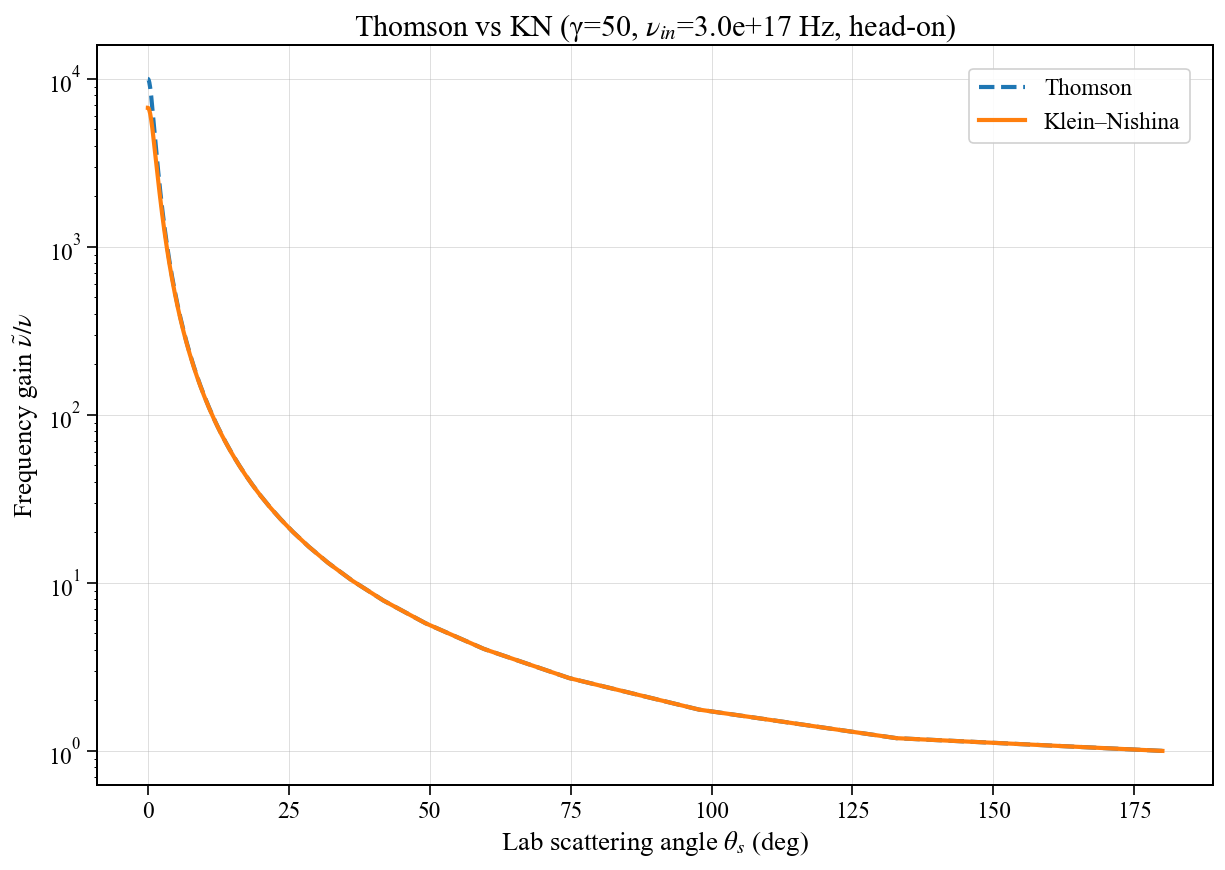

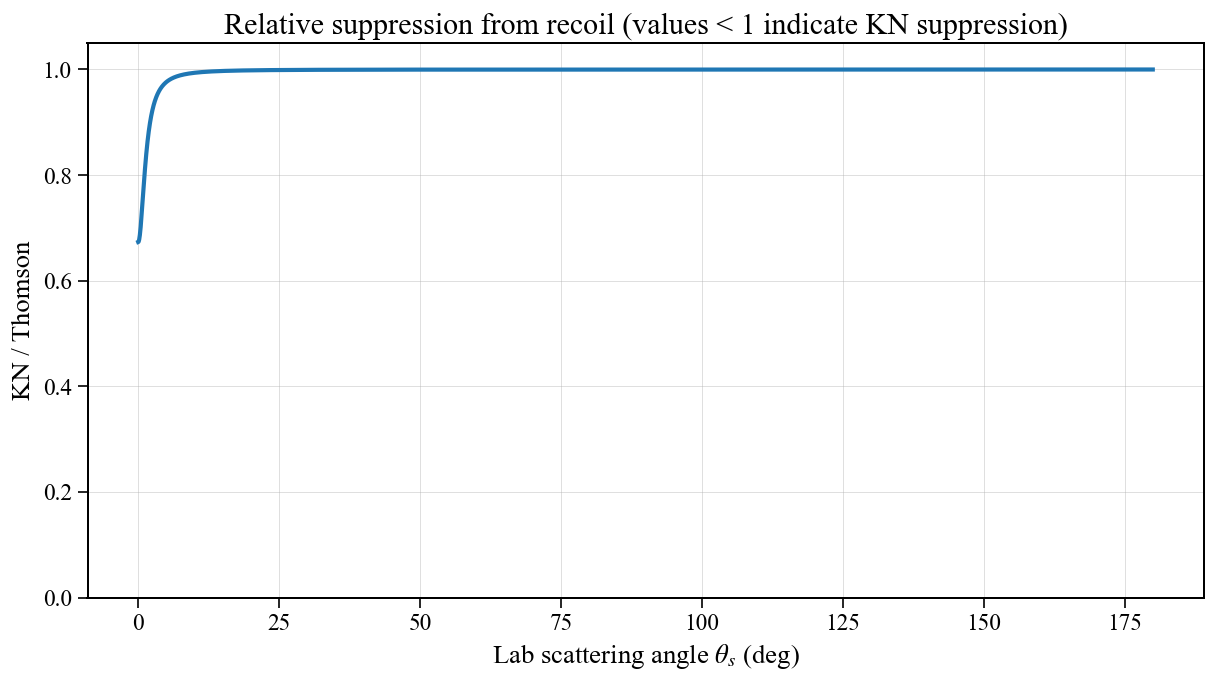

In [26]:
# --- Choose parameters to *see* KN suppression ---
gamma_val    = 50           # increase gamma
theta_in_deg = 180.0           # head-on incidence maximizes epsilon'
nu_in_hz     = 3e17            # push seed freq up (soft X-ray)

# Quick diagnostic: are we in KN?
beta = beta_from_gamma(gamma_val)
eps_lab = h * nu_in_hz
cos_theta_lab = np.cos(np.radians(theta_in_deg))
eps_prime = doppler_to_erf(eps_lab, cos_theta_lab, beta)        # ERF energy
me_c2 = me * c**2
print(f"epsilon'/mec^2 = {eps_prime/me_c2:.3f}   (>=0.1 => KN visible)")

# Compute both curves (your function)
theta_T,  gain_T  = ics_gain_vs_theta_lab(gamma_val, nu_in_hz, theta_in_deg,
                                          use_klein_nishina=False, n_angles=361)
theta_KN, gain_KN = ics_gain_vs_theta_lab(gamma_val, nu_in_hz, theta_in_deg,
                                          use_klein_nishina=True,  n_angles=361)

import numpy as np
mask = np.isfinite(theta_T) & np.isfinite(gain_T) & np.isfinite(gain_KN)
theta = theta_T[mask]; gT = np.asarray(gain_T)[mask]; gKN = np.asarray(gain_KN)[mask]

# Overlay (log y helps)
plt.figure(figsize=(12,8))
plt.plot(theta, gT,  '--', lw=2.5, label="Thomson")
plt.plot(theta, gKN, '-',  lw=2.5, label="Klein–Nishina")
plt.yscale('log')
plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel(r"Frequency gain $\tilde{\nu}/\nu$")
plt.title(rf"Thomson vs KN (γ={gamma_val:.0f}, $\nu_{{in}}$={nu_in_hz:.1e} Hz, head-on)")
plt.legend(); plt.grid(True); plt.show()

# Ratio plot
ratio = np.divide(gKN, gT, out=np.ones_like(gKN), where=(gT>0))
plt.figure(figsize=(12,6))
plt.plot(theta, ratio, lw=2.5)
plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel("KN / Thomson")
plt.ylim(0,1.05)
plt.title("Relative suppression from recoil (values < 1 indicate KN suppression)")
plt.grid(True); plt.show()


## Module A) Iteractive Plot

**What it shows.**  
The widget plots the **frequency gain** $\tilde{\nu}/\nu$ as a function of the **lab scattering angle** $\theta_s$ for the parameters you choose. Internally it:
1. boosts the incident photon (lab → ERF),
2. scatters by an ERF angle sweep $\Theta'$ using your chosen regime (Thomson or Klein–Nishina),
3. boosts the scattered photon back (ERF → lab),
4. computes $\tilde{\nu}/\nu = \nu_{\text{out}}/\nu_{\text{in}}$ and $\theta_s$,
5. draws the curve.

**Controls.**
- **$\gamma$ (Lorentz factor):** sets electron speed. Larger $\gamma$ ⇒ stronger forward beaming and higher gains near $\theta_s \approx 0^\circ$.
- **$\nu_{\rm in}$ (Hz):** incident photon frequency. Higher $\nu_{\rm in}$ can push you toward the KN regime (suppression at large angles).
- **$\theta_{\rm in}$ (deg):** incident photon direction in the lab, measured from the electron’s $+z$ direction. Head-on ($\theta_{\rm in}\!\approx\!180^\circ$) gives largest boosts.
- **Regime (Thomson / KN):** chooses whether the ERF energy shift is elastic (Thomson) or uses the full Klein–Nishina expression (includes recoil).
- **Resolution:** number of ERF angles $\Theta'$ sampled between $0$ and $\pi$. Higher values give smoother curves but are slower.

**How to read the plot.**
- The **peak near $\theta_s\!\approx\!0^\circ$** shows forward beaming; its height grows with $\gamma$.
- The **fall-off with angle** reflects relativistic aberration and (if KN is on) recoil losses.
- Switching to **Thomson** should increase the high-angle gain relative to **KN**, where recoil suppresses energy at large $\Theta'$.

**Typical experiments to try.**
- Fix $\nu_{\rm in}$, vary $\gamma$: watch the curve sharpen and rise near small angles.
- Fix $\gamma$, increase $\nu_{\rm in}$: see when KN suppression becomes noticeable (curve lowers at larger angles).
- Change $\theta_{\rm in}$: head-on incidence ($\sim\!180^\circ$) maximizes boosts; co-moving ($\sim\!0^\circ$) minimizes them.

**Numerical tips.**
- If the plot appears empty, lower resolution or check that parameters are physical (e.g., $\gamma \ge 1$).  
- If you see gaps, it’s typically from edge-case divisions in aberration; a small reduction in resolution or avoiding exactly $\Theta' = \pi$ can help.


In [14]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    gamma_slider = widgets.FloatLogSlider(value=10.0, base=10, min=0, max=3, step=0.01,
                                          description="gamma", readout_format=".2f")
    nu_slider = widgets.FloatLogSlider(value=1e14, base=10, min=8, max=22, step=0.01,
                                       description="nu_in [Hz]", readout_format=".2e")
    theta_in_slider = widgets.FloatSlider(value=0.0, min=0.0, max=180.0, step=1.0,
                                          description="theta_in [deg]")
    regime_toggle = widgets.ToggleButtons(options=[("Klein–Nishina", True), ("Thomson", False)],
                                          description="Regime")

    out = widgets.Output()

    def redraw(_=None):
        with out:
            clear_output(wait=True)
            theta_s, gain = ics_gain_vs_theta_lab(
                gamma=gamma_slider.value,
                nu_in_hz=nu_slider.value,
                theta_in_deg=theta_in_slider.value,
                use_klein_nishina=regime_toggle.value,
                n_angles=361
            )
            plt.figure()
            plt.plot(theta_s, gain, lw=2)
            plt.xlabel("Lab scattering angle theta_s (deg)")
            plt.ylabel("Frequency gain nu_out/nu_in")
            plt.title("Inverse Compton (interactive)")
            plt.grid(True)
            plt.show()

    for w in (gamma_slider, nu_slider, theta_in_slider, regime_toggle):
        w.observe(redraw, names="value")

    ui = widgets.VBox([gamma_slider, nu_slider, theta_in_slider, regime_toggle, out])
    display(ui)
    redraw()

except Exception as e:
    print("ipywidgets not available:", e)
    print("You can still use ics_gain_vs_theta_lab(...) and plot manually.")



## Module 2 — Isotropic Soft-Photon Field (Monte Carlo)
Here we assume soft photons are isotropic in the lab and we let a monoenergetic electron scatter them once.
We show histograms for the lab scattering angle** and the frequency gain. The ERF scattering angle is sampled from the Thomsondistribution; for energy we allow Thomson or Klein–Nishina.

In [15]:
import numpy as np

def sample_thomson_cosTheta_prime(n: int, rng=None) -> np.ndarray:
    """Sample cos(Theta') in ERF with Thomson angular weight ∝ (1+cos^2 Theta')."""
    if rng is None:
        rng = np.random.default_rng()
    out = []
    while len(out) < n:
        u = rng.uniform(-1.0, 1.0, size=n)  # proposal for cos(Theta')
        y = rng.uniform(0.0, 1.0, size=n)
        w = 0.5 * (1.0 + u*u)               # normalized to max 1 at |u|=1
        accept = y < w
        out.extend(u[accept].tolist())
    return np.array(out[:n])

def ics_isotropic_soft_photons(gamma: float = 10.0, nu_in_hz: float = 1e12,
                               n_phot: int = 5000, use_klein_nishina: bool = True, seed: int = 123):
    """Monoenergetic photons isotropic in LAB → single scatter → LAB outputs (theta_s, gain, energies)."""
    rng = np.random.default_rng(seed)
    beta = beta_from_gamma(gamma)
    eps_lab = h * nu_in_hz

    # Isotropic incidence in LAB
    cos_theta_lab_in = rng.uniform(-1.0, 1.0, size=n_phot)

    # LAB → ERF
    eps_prime_in = doppler_to_erf(eps_lab, cos_theta_lab_in, beta)
    cos_theta_prime_in = aberration_lab_to_erf(cos_theta_lab_in, beta)

    # ERF scatter angle (Thomson angular weighting)
    cos_Theta_prime = sample_thomson_cosTheta_prime(n_phot, rng=rng)

    # ERF outgoing angle relative to +z
    theta_prime_in = np.arccos(np.clip(cos_theta_prime_in, -1, 1))
    sin_theta_prime_in = np.sin(theta_prime_in)
    sin_Theta = np.sqrt(1.0 - cos_Theta_prime**2)
    cos_theta_prime_out = cos_theta_prime_in * cos_Theta_prime + sin_theta_prime_in * sin_Theta

    # ERF scattered energy
    if use_klein_nishina:
        eps_prime_out = epsilon_s_erf_kn(eps_prime_in, cos_Theta_prime)
    else:
        eps_prime_out = eps_prime_in  # Thomson: elastic in ERF

    # ERF → LAB
    eps_out = doppler_to_lab(eps_prime_out, cos_theta_prime_out, beta)
    nu_out = eps_out / h

    # LAB scattering angle
    cos_theta_lab_out = aberration_erf_to_lab(cos_theta_prime_out, beta)
    theta_lab_out = np.degrees(np.arccos(np.clip(cos_theta_lab_out, -1.0, 1.0)))

    gain = nu_out / nu_in_hz
    return theta_lab_out, gain, eps_out, eps_lab


samples: 8000  |  θ valid: 8000  |  gain valid: 8000


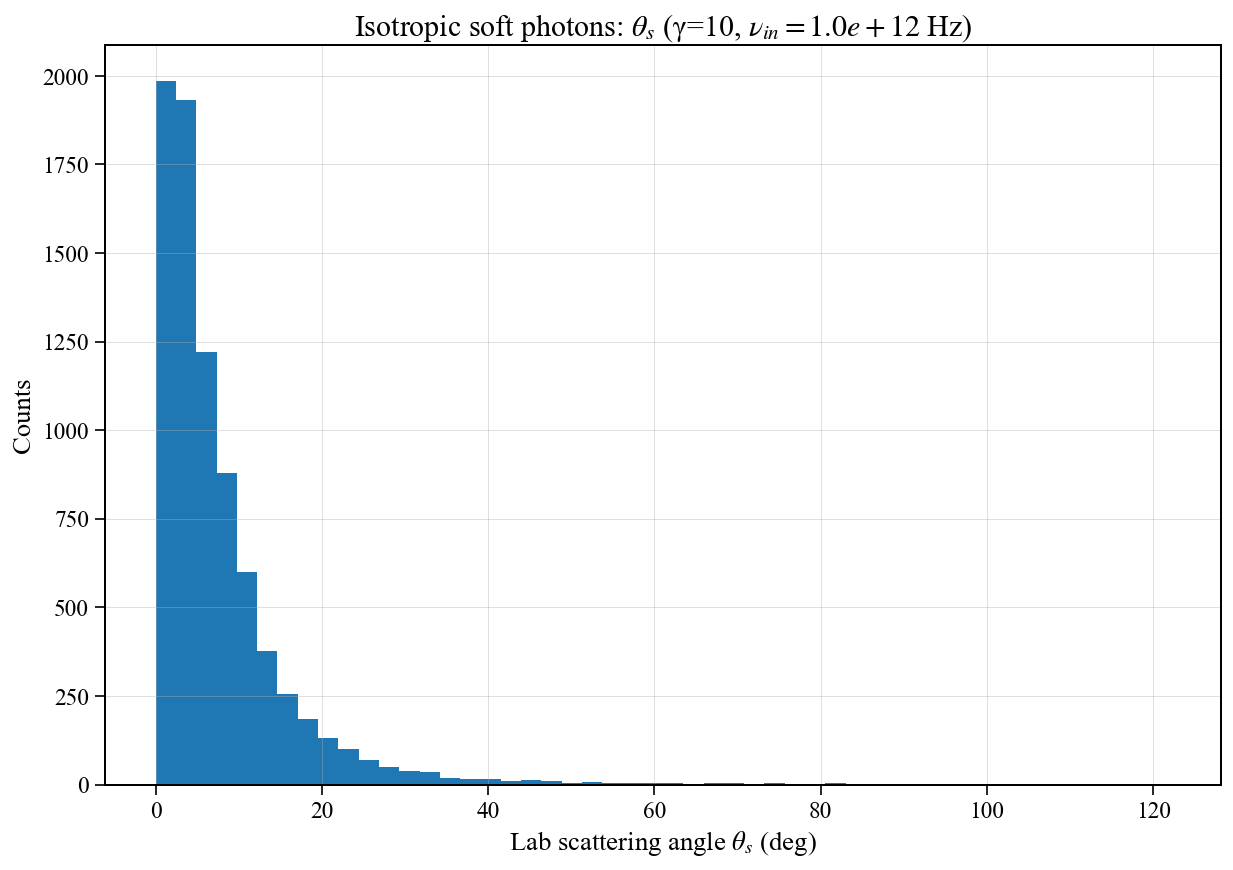

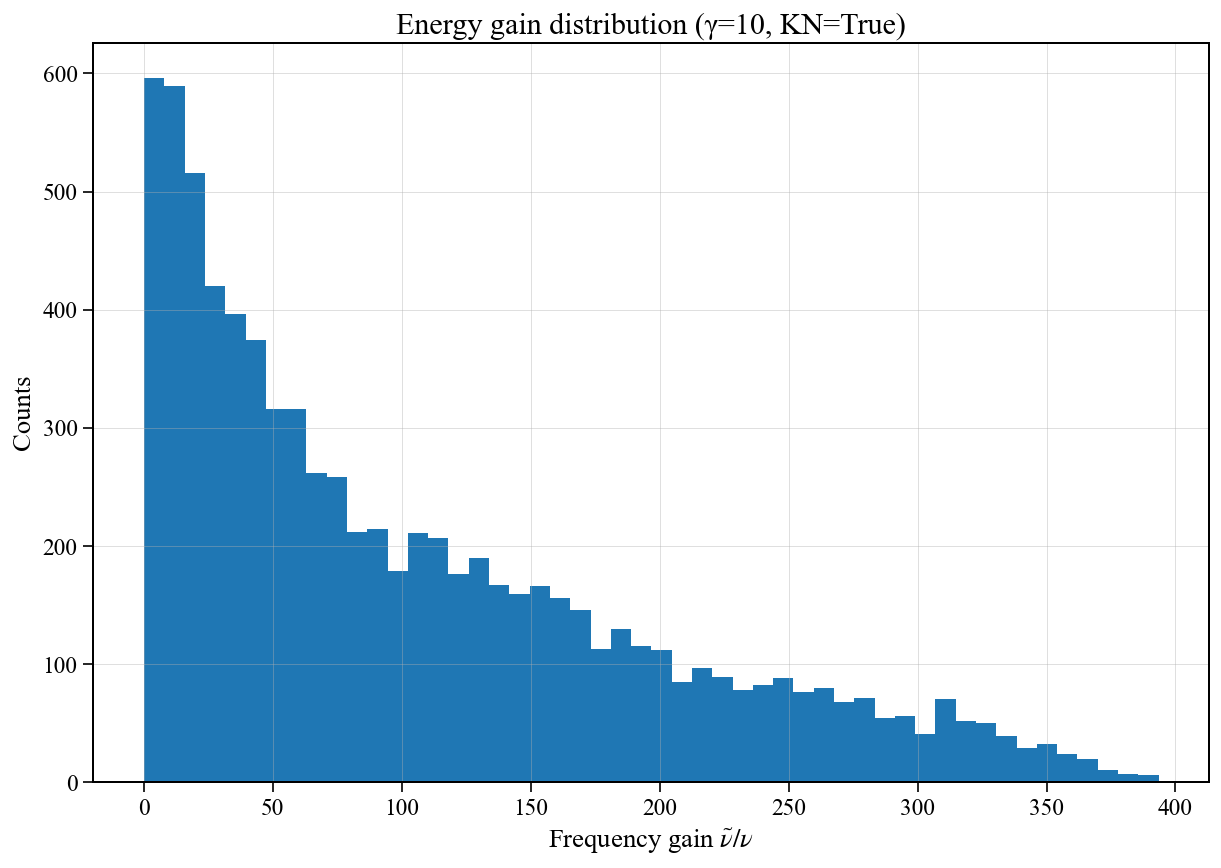

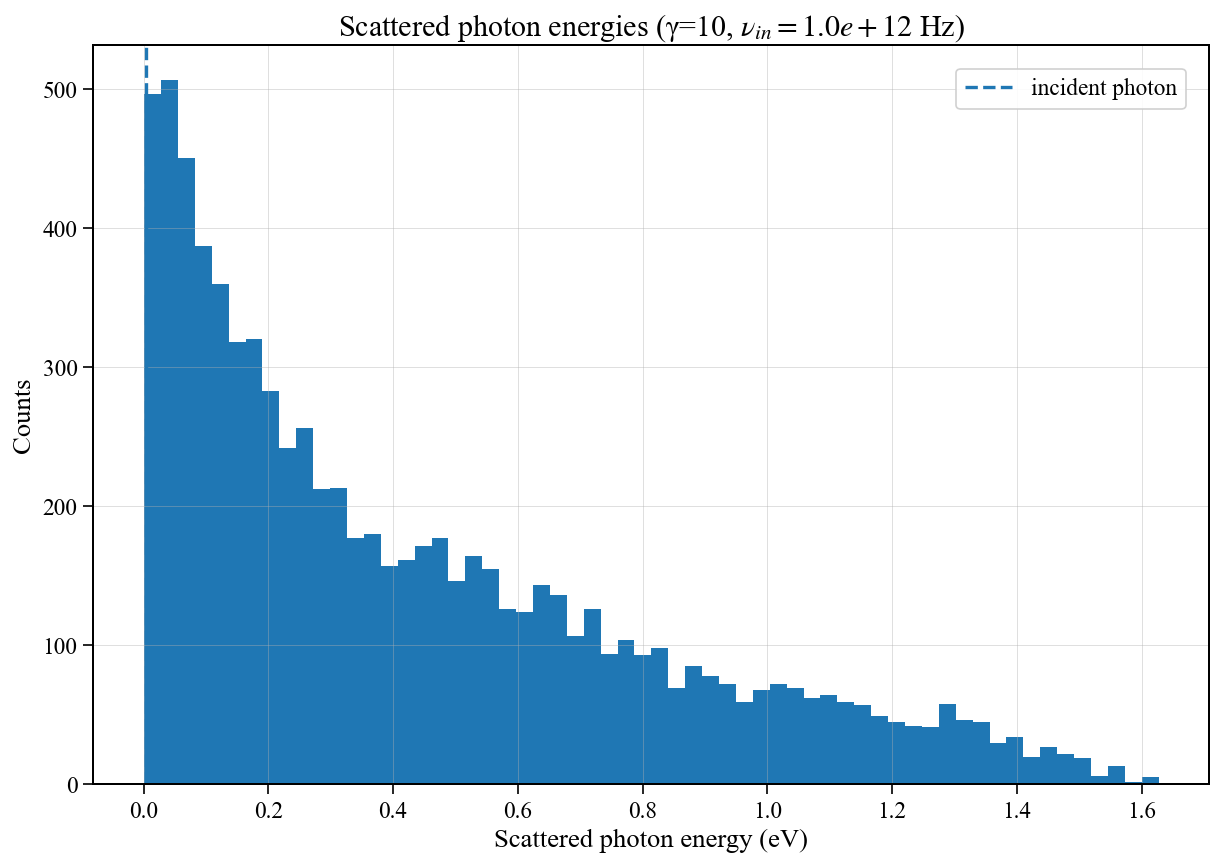

In [16]:
# ---- RESCUE CELL: makes Plots 5, 6, and energy plot appear ----
import numpy as np
import matplotlib.pyplot as plt

# 0) Constants (ensure eV exists)
eV = 1.602176634e-19   # J per eV

# 1) Parameters (tweak if you like)
gamma_plot = 10.0
nu_in_plot = 1e12
n_samples  = 8000
use_kn     = True
rng_seed   = 42

# 2) Required helpers (only if not already defined)
def sample_thomson_cosTheta_prime(n: int, rng=None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng()
    out = []
    while len(out) < n:
        u = rng.uniform(-1.0, 1.0, size=n)  # proposal cos(Theta')
        y = rng.uniform(0.0, 1.0, size=n)
        w = 0.5 * (1.0 + u*u)                # normalized to max 1
        accept = y < w
        out.extend(u[accept].tolist())
    return np.array(out[:n])

def doppler_to_lab(epsilon_erf_J, cos_theta_prime_out, beta: float):
    g = gamma_from_beta(beta)
    eps  = np.asarray(epsilon_erf_J, dtype=float)
    cosp = np.clip(np.asarray(cos_theta_prime_out, dtype=float), -1.0, 1.0)
    return g * eps * (1.0 + beta * cosp)

def aberration_erf_to_lab(cos_theta_prime_out, beta: float):
    cosp = np.clip(np.asarray(cos_theta_prime_out, dtype=float), -1.0, 1.0)
    num = cosp + beta
    den = 1.0 + beta * cosp
    return np.clip(num/den, -1.0, 1.0)

def ics_isotropic_soft_photons(gamma: float, nu_in_hz: float, n_phot: int,
                               use_klein_nishina: bool=True, seed: int=123):
    rng = np.random.default_rng(seed)
    beta = beta_from_gamma(gamma)
    eps_lab = h * nu_in_hz

    # Isotropic incidence in LAB
    cos_theta_lab_in = rng.uniform(-1.0, 1.0, size=n_phot)

    # LAB -> ERF
    eps_prime_in = doppler_to_erf(eps_lab, cos_theta_lab_in, beta)
    cos_theta_prime_in = aberration_lab_to_erf(cos_theta_lab_in, beta)

    # ERF scatter angle (Thomson weight)
    cos_Theta_prime = sample_thomson_cosTheta_prime(n_phot, rng=rng)

    # ERF outgoing direction wrt +z
    theta_prime_in = np.arccos(np.clip(cos_theta_prime_in, -1, 1))
    sin_theta_prime_in = np.sin(theta_prime_in)
    sin_Theta = np.sqrt(1.0 - cos_Theta_prime**2)
    cos_theta_prime_out = (cos_theta_prime_in * cos_Theta_prime
                           + sin_theta_prime_in * sin_Theta)

    # ERF scattered energy
    if use_klein_nishina:
        eps_prime_out = epsilon_s_erf_kn(eps_prime_in, cos_Theta_prime)
    else:
        eps_prime_out = eps_prime_in  # Thomson: elastic in ERF

    # ERF -> LAB
    eps_out = doppler_to_lab(eps_prime_out, cos_theta_prime_out, beta)
    nu_out  = eps_out / h
    gain    = nu_out / nu_in_hz

    # LAB angle
    cos_theta_lab_out = aberration_erf_to_lab(cos_theta_prime_out, beta)
    theta_lab_out = np.degrees(np.arccos(np.clip(cos_theta_lab_out, -1.0, 1.0)))

    return theta_lab_out, gain, eps_out, eps_lab

# 3) Generate samples
theta_samp, gain_samp, eps_out_samp, eps_in_J = ics_isotropic_soft_photons(
    gamma=gamma_plot, nu_in_hz=nu_in_plot, n_phot=n_samples,
    use_klein_nishina=use_kn, seed=rng_seed
)

# 4) Sanity print
print(f"samples: {len(theta_samp)}  |  θ valid: {np.isfinite(theta_samp).sum()}  |  gain valid: {np.isfinite(gain_samp).sum()}")

# 5) Plot 5 — Histogram of θ_s
plt.figure(figsize=(12,8))
plt.hist(theta_samp[np.isfinite(theta_samp)], bins=50)
plt.xlabel(r"Lab scattering angle $\theta_s$ (deg)")
plt.ylabel("Counts")
plt.title(rf"Isotropic soft photons: $\theta_s$ (γ={gamma_plot:.0f}, $\nu_{{in}}={nu_in_plot:.1e}$ Hz)")
plt.grid(True)
plt.show()

# 6) Plot 6 — Histogram of energy gain
plt.figure(figsize=(12,8))
plt.hist(gain_samp[np.isfinite(gain_samp)], bins=50)
plt.xlabel(r"Frequency gain $\tilde{\nu}/\nu$")
plt.ylabel("Counts")
plt.title(rf"Energy gain distribution (γ={gamma_plot:.0f}, KN={use_kn})")
plt.grid(True)
plt.show()

# 7) Energy plot — scattered photon energies (eV); with incident & electron kinetic for context
eps_out_eV = eps_out_samp / eV
eps_in_eV  = eps_in_J / eV
E_e_kin_eV = ((gamma_plot - 1.0) * me * c**2) / eV

plt.figure(figsize=(12,8))
plt.hist(eps_out_eV[np.isfinite(eps_out_eV)], bins=60)
plt.axvline(eps_in_eV, linestyle="--", linewidth=2, label="incident photon")
# plt.axvline(E_e_kin_eV, linestyle=":", linewidth=2, label=r"electron kinetic $(\gamma-1)m_ec^2$")
plt.xlabel("Scattered photon energy (eV)")
plt.ylabel("Counts")
plt.title(rf"Scattered photon energies (γ={gamma_plot:.0f}, $\nu_{{in}}={nu_in_plot:.1e}$ Hz)")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
eps_clean = eps_out_eV[np.isfinite(eps_out_eV)]



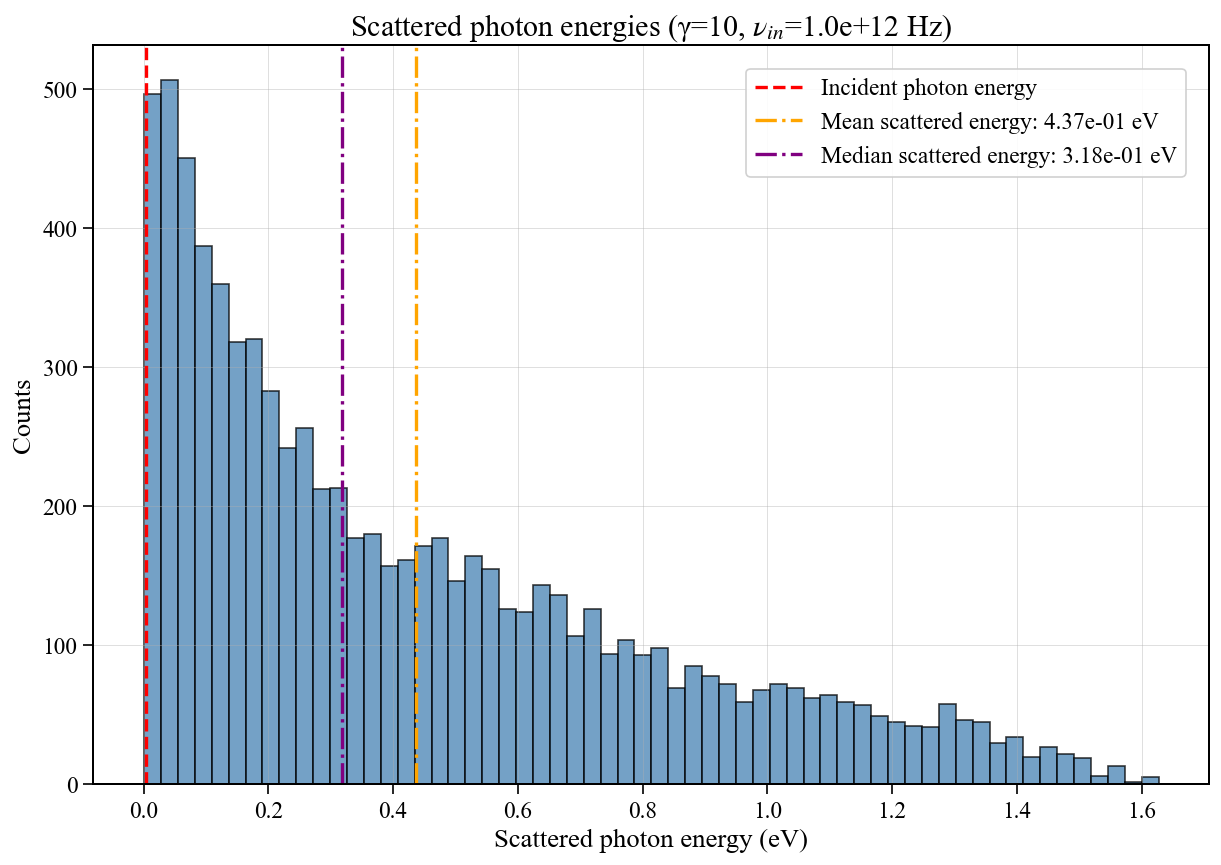

In [20]:
# --- Compute reference energies if not already defined ---
eps_in_eV = eps_in_J / eV                         # incident photon energy (eV)
E_e_kin_eV = ((gamma_plot - 1.0) * me * c**2) / eV   # electron kinetic energy (eV)

# Mean and median scattered photon energy
mean_e = np.nanmean(eps_clean)
median_e = np.nanmedian(eps_clean)

# --- Plot ---
plt.figure(figsize=(12,8))
plt.hist(eps_clean, bins=60, alpha=0.75, color="steelblue", edgecolor="black")

# Vertical reference lines
plt.axvline(eps_in_eV, color="red", linestyle="--", linewidth=2,
            label="Incident photon energy")

# plt.axvline(E_e_kin_eV, color="green", linestyle=":", linewidth=2.5,
#             label=r"Electron kinetic energy $(\gamma-1)m_ec^2$")

plt.axvline(mean_e, color="orange", linestyle="-.", linewidth=2,
            label=f"Mean scattered energy: {mean_e:.2e} eV")

plt.axvline(median_e, color="purple", linestyle="dashdot", linewidth=2,
            label=f"Median scattered energy: {median_e:.2e} eV")

# Labels, title, etc.
plt.xlabel("Scattered photon energy (eV)")
plt.ylabel("Counts")
plt.title(rf"Scattered photon energies (γ={gamma_plot:.0f}, $\nu_{{in}}$={nu_in_plot:.1e} Hz)")

plt.legend()
plt.grid(True)
plt.show()
